In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# 设置Cityscapes数据集路径
CITYSCAPES_PATH = 'archive'

# 加载图像和标签
def load_cityscapes_data(image_set='train'):
    images = []
    labels = []
    img_path = os.path.join(CITYSCAPES_PATH, image_set, 'img')
    label_path = os.path.join(CITYSCAPES_PATH, image_set, 'label')
    
    img_files = os.listdir(img_path)
    label_files = os.listdir(label_path)
    
    for img_file, label_file in zip(img_files, label_files):
        if not img_file.lower().endswith('.png') or not label_file.lower().endswith('.png'):
            continue
        
        img = cv2.imread(os.path.join(img_path, img_file))
        label = cv2.imread(os.path.join(label_path, label_file), cv2.IMREAD_GRAYSCALE)
        
        if img is None or label is None:
            print(f"Error reading image {img_file} or label {label_file}")
            continue
        
        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# 加载训练数据
train_images, train_labels = load_cityscapes_data('train')
# 加载验证数据
val_images, val_labels = load_cityscapes_data('val')

# 正则化图像数据
train_images = train_images / 255.0
val_images = val_images / 255.0

# 将标签转换为整数类型
train_labels = train_labels.astype(np.int32)
val_labels = val_labels.astype(np.int32)

# 构建DeepLabV3+模型
def DeepLabV3Plus(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Atrous Spatial Pyramid Pooling
    b4 = layers.GlobalAveragePooling2D()(base_model.output)
    b4 = layers.Reshape((1, 1, b4.shape[-1]))(b4)
    b4 = layers.Conv2D(256, (1, 1), padding='same')(b4)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.ReLU()(b4)
    b4 = layers.UpSampling2D((input_shape[0] // 4, input_shape[1] // 4), interpolation='bilinear')(b4)

    b0 = layers.Conv2D(256, (1, 1), padding='same')(base_model.output)
    b0 = layers.BatchNormalization()(b0)
    b0 = layers.ReLU()(b0)

    b1 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=6)(base_model.output)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.ReLU()(b1)

    b2 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=12)(base_model.output)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.ReLU()(b2)

    b3 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=18)(base_model.output)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.ReLU()(b3)

    x = layers.Concatenate()([b4, b0, b1, b2, b3])
    x = layers.Conv2D(256, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((input_shape[0] // 4, input_shape[1] // 4), interpolation='bilinear')(x)

    x = layers.Concatenate()([
        x,
        layers.Conv2D(48, (1, 1), padding='same')(base_model.get_layer('conv2_block3_1_relu').output)
    ])
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_classes, (1, 1), padding='same')(x)
    x = layers.UpSampling2D((4, 4), interpolation='bilinear')(x)

    return models.Model(inputs=base_model.input, outputs=x)

# 输入图像的形状
input_shape = train_images.shape[1:]

# 创建DeepLabV3+模型
model = DeepLabV3Plus(input_shape=input_shape, num_classes=3)  # 假设有3个类别

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=16)

# 绘制训练和验证的损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 绘制训练和验证的准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# 预测一个示例
predicted_label = model.predict(np.expand_dims(val_images[0], axis=0))
predicted_label = np.argmax(predicted_label, axis=-1)[0]

# 显示原始图像、标签和预测结果
def display_prediction(original, label, prediction):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title('Label Image')
    plt.imshow(label)
    plt.subplot(1, 3, 3)
    plt.title('Prediction Image')
    plt.imshow(prediction)
    plt.show()

display_prediction(val_images[0], val_labels[0], predicted_label)


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# 设置Cityscapes数据集路径
CITYSCAPES_PATH = 'archive'

# 验证路径和文件
def verify_image_files(image_set='train'):
    img_path = os.path.join(CITYSCAPES_PATH, image_set, 'img')
    label_path = os.path.join(CITYSCAPES_PATH, image_set, 'label')
    
    if not os.path.exists(img_path):
        print(f"Image path does not exist: {img_path}")
        return False
    
    if not os.path.exists(label_path):
        print(f"Label path does not exist: {label_path}")
        return False
    
    img_files = os.listdir(img_path)
    label_files = os.listdir(label_path)
    
    if not img_files:
        print(f"No image files found in directory: {img_path}")
        return False
    
    if not label_files:
        print(f"No label files found in directory: {label_path}")
        return False
    
    for img_file, label_file in zip(img_files, label_files):
        if not img_file.lower().endswith('.png') or not label_file.lower().endswith('.png'):
            print(f"File {img_file} or {label_file} is not a .png file")
            continue
        
        img = cv2.imread(os.path.join(img_path, img_file))
        label = cv2.imread(os.path.join(label_path, label_file))
        
        if img is None:
            print(f"Error reading image {img_file}")
            continue
        
        if label is None:
            print(f"Error reading label {label_file}")
            continue
        
        print(f"Successfully read image {img_file} and label {label_file}")
    
    return True

# 验证训练集路径和文件
if not verify_image_files('train'):
    print("Training data verification failed. Please check the data path and format.")

# 验证验证集路径和文件
if not verify_image_files('val'):
    print("Validation data verification failed. Please check the data path and format.")

# 加载图像和标签
def load_cityscapes_data(image_set='train'):
    images = []
    labels = []
    img_path = os.path.join(CITYSCAPES_PATH, image_set, 'img')
    label_path = os.path.join(CITYSCAPES_PATH, image_set, 'label')
    
    img_files = os.listdir(img_path)
    label_files = os.listdir(label_path)
    
    for img_file, label_file in zip(img_files, label_files):
        if not img_file.lower().endswith('.png') or not label_file.lower().endswith('.png'):
            continue
        
        img = cv2.imread(os.path.join(img_path, img_file))
        label = cv2.imread(os.path.join(label_path, label_file))
        
        if img is None or label is None:
            print(f"Error reading image {img_file} or label {label_file}")
            continue
        
        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# 加载训练数据
train_images, train_labels = load_cityscapes_data('train')

# 加载验证数据
val_images, val_labels = load_cityscapes_data('val')

# 显示示例图像
def display_images(original, label):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title('Label Image')
    plt.imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
    plt.show()

# 显示一个示例
if len(train_images) > 0:
    display_images(train_images[0], train_labels[0])
else:
    print("No training images loaded.")
# 正则化图像数据
train_images = train_images / 255.0
val_images = val_images / 255.0

# 将标签转换为整数类型
train_labels = train_labels.astype(np.int32)
val_labels = val_labels.astype(np.int32)

Successfully read image train1.png and label train1.png
Successfully read image train10.png and label train10.png
Successfully read image train100.png and label train100.png
Successfully read image train1000.png and label train1000.png
Successfully read image train1001.png and label train1001.png
Successfully read image train1002.png and label train1002.png
Successfully read image train1003.png and label train1003.png
Successfully read image train1004.png and label train1004.png
Successfully read image train1005.png and label train1005.png
Successfully read image train1006.png and label train1006.png
Successfully read image train1007.png and label train1007.png
Successfully read image train1008.png and label train1008.png
Successfully read image train1009.png and label train1009.png
Successfully read image train101.png and label train101.png
Successfully read image train1010.png and label train1010.png
Successfully read image train1011.png and label train1011.png
Successfully read imag

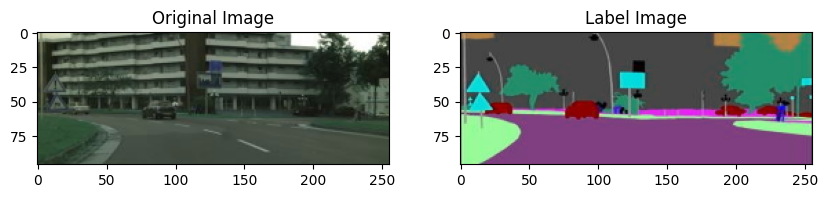

Input shape: (2975, 96, 256, 3)


ValueError: `input_shape` must be a tuple of three integers.

In [9]:

# 构建DeepLabV3+模型
def DeepLabV3Plus(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Atrous Spatial Pyramid Pooling
    b4 = layers.GlobalAveragePooling2D()(base_model.output)
    b4 = layers.Reshape((1, 1, b4.shape[-1]))(b4)
    b4 = layers.Conv2D(256, (1, 1), padding='same')(b4)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.ReLU()(b4)
    b4 = layers.UpSampling2D(size=(input_shape[0] // 32, input_shape[1] // 32), interpolation='bilinear')(b4)

    b0 = layers.Conv2D(256, (1, 1), padding='same')(base_model.output)
    b0 = layers.BatchNormalization()(b0)
    b0 = layers.ReLU()(b0)

    b1 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=6)(base_model.output)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.ReLU()(b1)

    b2 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=12)(base_model.output)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.ReLU()(b2)

    b3 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=18)(base_model.output)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.ReLU()(b3)

    x = layers.Concatenate()([b4, b0, b1, b2, b3])
    x = layers.Conv2D(256, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D(size=(input_shape[0] // 4, input_shape[1] // 4), interpolation='bilinear')(x)

    low_level_feature = base_model.get_layer('conv2_block3_1_relu').output
    low_level_feature = layers.Conv2D(48, (1, 1), padding='same')(low_level_feature)
    low_level_feature = layers.BatchNormalization()(low_level_feature)
    low_level_feature = layers.ReLU()(low_level_feature)

    x = layers.Concatenate()([x, low_level_feature])
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_classes, (1, 1), padding='same')(x)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    return models.Model(inputs=base_model.input, outputs=x)

# 确保 `input_shape` 是正确的
input_shape = train_images.shape[0:]  # 形如 (height, width, channels)

# 打印 `input_shape` 以确认
print("Input shape:", input_shape)

# 创建DeepLabV3+模型
model = DeepLabV3Plus(input_shape=input_shape, num_classes=3)  # 假设有3个类别

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=16)

# 绘制训练和验证的损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 绘制训练和验证的准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# 预测一个示例
predicted_label = model.predict(np.expand_dims(val_images[0], axis=0))
predicted_label = np.argmax(predicted_label, axis=-1)[0]

# 显示原始图像、标签和预测结果
def display_prediction(original, label, prediction):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title('Label Image')
    plt.imshow(label)
    plt.subplot(1, 3, 3)
    plt.title('Prediction Image')
    plt.imshow(prediction)
    plt.show()

display_prediction(val_images[0], val_labels[0], predicted_label)
# # 构建DeepLabV3+模型
# def DeepLabV3Plus(input_shape, num_classes):
#     base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

#     # Atrous Spatial Pyramid Pooling
#     b4 = layers.GlobalAveragePooling2D()(base_model.output)
#     b4 = layers.Reshape((1, 1, b4.shape[-1]))(b4)
#     b4 = layers.Conv2D(256, (1, 1), padding='same')(b4)
#     b4 = layers.BatchNormalization()(b4)
#     b4 = layers.ReLU()(b4)
#     b4 = layers.UpSampling2D((input_shape[0] // 4, input_shape[1] // 4), interpolation='bilinear')(b4)

#     b0 = layers.Conv2D(256, (1, 1), padding='same')(base_model.output)
#     b0 = layers.BatchNormalization()(b0)
#     b0 = layers.ReLU()(b0)

#     b1 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=6)(base_model.output)
#     b1 = layers.BatchNormalization()(b1)
#     b1 = layers.ReLU()(b1)

#     b2 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=12)(base_model.output)
#     b2 = layers.BatchNormalization()(b2)
#     b2 = layers.ReLU()(b2)

#     b3 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=18)(base_model.output)
#     b3 = layers.BatchNormalization()(b3)
#     b3 = layers.ReLU()(b3)

#     x = layers.Concatenate()([b4, b0, b1, b2, b3])
#     x = layers.Conv2D(256, (1, 1), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.UpSampling2D((input_shape[0] // 4, input_shape[1] // 4), interpolation='bilinear')(x)

#     x = layers.Concatenate()([
#         x,
#         layers.Conv2D(48, (1, 1), padding='same')(base_model.get_layer('conv2_block3_1_relu').output)
#     ])
#     x = layers.Conv2D(256, (3, 3), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.Conv2D(256, (3, 3), padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     x = layers.Conv2D(num_classes, (1, 1), padding='same')(x)
#     x = layers.UpSampling2D((4, 4), interpolation='bilinear')(x)

#     return models.Model(inputs=base_model.input, outputs=x)

# # 输入图像的形状
# input_shape = train_images.shape[1:]

# # 打印 `input_shape` 以确认
# print("Input shape:", input_shape)

# # 创建DeepLabV3+模型
# model = DeepLabV3Plus(input_shape=input_shape, num_classes=3)  # 假设有3个类别

# # 编译模型
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # 训练模型
# history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=16)

# # 绘制训练和验证的损失曲线
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.show()

# # 绘制训练和验证的准确率曲线
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.legend()
# plt.show()

# # 预测一个示例
# predicted_label = model.predict(np.expand_dims(val_images[0], axis=0))
# predicted_label = np.argmax(predicted_label, axis=-1)[0]

# # 显示原始图像、标签和预测结果
# def display_prediction(original, label, prediction):
#     plt.figure(figsize=(15, 5))
#     plt.subplot(1, 3, 1)
#     plt.title('Original Image')
#     plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
#     plt.subplot(1, 3, 2)
#     plt.title('Label Image')
#     plt.imshow(label)
#     plt.subplot(1, 3, 3)
#     plt.title('Prediction Image')
#     plt.imshow(prediction)
#     plt.show()

# display_prediction(val_images[0], val_labels[0], predicted_label)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50

def DeepLabV3Plus(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Atrous Spatial Pyramid Pooling
    b4 = layers.GlobalAveragePooling2D()(base_model.output)
    b4 = layers.Reshape((1, 1, b4.shape[-1]))(b4)
    b4 = layers.Conv2D(256, (1, 1), padding='same')(b4)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.ReLU()(b4)
    b4 = layers.UpSampling2D((input_shape[0] // 4, input_shape[1] // 4), interpolation='bilinear')(b4)

    b0 = layers.Conv2D(256, (1, 1), padding='same')(base_model.output)
    b0 = layers.BatchNormalization()(b0)
    b0 = layers.ReLU()(b0)

    b1 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=6)(base_model.output)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.ReLU()(b1)

    b2 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=12)(base_model.output)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.ReLU()(b2)

    b3 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=18)(base_model.output)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.ReLU()(b3)

    x = layers.Concatenate()([b4, b0, b1, b2, b3])
    x = layers.Conv2D(256, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((input_shape[0] // 4, input_shape[1] // 4), interpolation='bilinear')(x)

    x = layers.Concatenate()([
        x,
        layers.Conv2D(48, (1, 1), padding='same')(base_model.get_layer('conv2_block3_1_relu').output)
    ])
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_classes, (1, 1), padding='same')(x)
    x = layers.UpSampling2D((4, 4), interpolation='bilinear')(x)

    return models.Model(inputs=base_model.input, outputs=x)

# 输入图像的形状
input_shape = train_images.shape[1:]

# 创建DeepLabV3+模型
model = DeepLabV3Plus(input_shape=input_shape, num_classes=3)  # 假设有3个类别

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=16)


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50

def DeepLabV3Plus(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Atrous Spatial Pyramid Pooling
    b4 = layers.GlobalAveragePooling2D()(base_model.output)
    b4 = layers.Reshape((1, 1, b4.shape[-1]))(b4)
    b4 = layers.Conv2D(256, (1, 1), padding='same')(b4)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.ReLU()(b4)
    b4 = layers.UpSampling2D((input_shape[0] // 4, input_shape[1] // 4), interpolation='bilinear')(b4)

    b0 = layers.Conv2D(256, (1, 1), padding='same')(base_model.output)
    b0 = layers.BatchNormalization()(b0)
    b0 = layers.ReLU()(b0)

    b1 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=6)(base_model.output)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.ReLU()(b1)

    b2 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=12)(base_model.output)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.ReLU()(b2)

    b3 = layers.Conv2D(256, (3, 3), padding='same', dilation_rate=18)(base_model.output)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.ReLU()(b3)

    x = layers.Concatenate()([b4, b0, b1, b2, b3])
    x = layers.Conv2D(256, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((input_shape[0] // 4, input_shape[1] // 4), interpolation='bilinear')(x)

    x = layers.Concatenate()([
        x,
        layers.Conv2D(48, (1, 1), padding='same')(base_model.get_layer('conv2_block3_1_relu').output)
    ])
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_classes, (1, 1), padding='same')(x)
    x = layers.UpSampling2D((4, 4), interpolation='bilinear')(x)

    return models.Model(inputs=base_model.input, outputs=x)

# 输入图像的形状
input_shape = train_images.shape[1:]

# 创建DeepLabV3+模型
model = DeepLabV3Plus(input_shape=input_shape, num_classes=3)  # 假设有3个类别

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=16)


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 设置Cityscapes数据集路径
CITYSCAPES_PATH = r'D:/py/语义分割/archive'

# 验证路径和文件
def verify_image_files(image_set='train'):
    img_path = os.path.join(CITYSCAPES_PATH, image_set, 'img')
    label_path = os.path.join(CITYSCAPES_PATH, image_set, 'label')
    
    if not os.path.exists(img_path):
        print(f"Image path does not exist: {img_path}")
        return False
    
    if not os.path.exists(label_path):
        print(f"Label path does not exist: {label_path}")
        return False
    
    img_files = os.listdir(img_path)
    label_files = os.listdir(label_path)
    
    if not img_files:
        print(f"No image files found in directory: {img_path}")
        return False
    
    if not label_files:
        print(f"No label files found in directory: {label_path}")
        return False
    
    for img_file, label_file in zip(img_files, label_files):
        if not img_file.lower().endswith('.jpg') or not label_file.lower().endswith('.jpg'):
            print(f"File {img_file} or {label_file} is not a .jpg file")
            continue
        
        img = cv2.imread(os.path.join(img_path, img_file))
        label = cv2.imread(os.path.join(label_path, label_file))
        
        if img is None:
            print(f"Error reading image {img_file}")
            continue
        
        if label is None:
            print(f"Error reading label {label_file}")
            continue
        
        print(f"Successfully read image {img_file} and label {label_file}")
    
    return True

# 验证训练集路径和文件
if not verify_image_files('train'):
    print("Training data verification failed. Please check the data path and format.")

# 验证验证集路径和文件
if not verify_image_files('val'):
    print("Validation data verification failed. Please check the data path and format.")

# 加载图像和标签
def load_cityscapes_data(image_set='train'):
    images = []
    labels = []
    img_path = os.path.join(CITYSCAPES_PATH, image_set, 'img')
    label_path = os.path.join(CITYSCAPES_PATH, image_set, 'label')
    
    img_files = os.listdir(img_path)
    label_files = os.listdir(label_path)
    
    for img_file, label_file in zip(img_files, label_files):
        if not img_file.lower().endswith('.jpg') or not label_file.lower().endswith('.jpg'):
            continue
        
        img = cv2.imread(os.path.join(img_path, img_file))
        label = cv2.imread(os.path.join(label_path, label_file))
        
        if img is None or label is None:
            print(f"Error reading image {img_file} or label {label_file}")
            continue
        
        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# 加载训练数据
train_images, train_labels = load_cityscapes_data('train')

# 加载验证数据
val_images, val_labels = load_cityscapes_data('val')

# 显示示例图像
def display_images(original, label):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title('Label Image')
    plt.imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
    plt.show()

# 显示一个示例
if len(train_images) > 0:
    display_images(train_images[0], train_labels[0])
else:
    print("No training images loaded.")
    



In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf

# 设置Cityscapes数据集路径
CITYSCAPES_PATH = 'D:/py\语义分割\cityscapes_data'

# 加载Cityscapes图像和标注
def load_cityscapes_data(split='train'):
    images = []
    masks = []
    image_path = os.path.join(CITYSCAPES_PATH, 'leftImg8bit', split)
    mask_path = os.path.join(CITYSCAPES_PATH, 'gtFine', split)

    cities = os.listdir(image_path)
    for city in cities:
        img_dir = os.path.join(image_path, city)
        mask_dir = os.path.join(mask_path, city)
        img_files = os.listdir(img_dir)
        for img_file in img_files:
            img = cv2.imread(os.path.join(img_dir, img_file))
            mask_file = img_file.replace('leftImg8bit', 'gtFine_labelIds')
            mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
            images.append(img)
            masks.append(mask)
    return np.array(images), np.array(masks)

# 加载训练数据
train_images, train_masks = load_cityscapes_data('train')


In [ ]:
# 构建U-Net模型
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # 下采样部分
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # 上采样部分
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(3, (1, 1), activation='softmax')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 输入图像的形状
input_shape = train_images.shape[1:]

# 创建U-Net模型
model = unet_model(input_shape)

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=16)


In [ ]:
# 提取感兴趣区域
def extract_interesting_areas(segmentation_map):
    # 例如，提取人行道和绿地区域
    sidewalk = (segmentation_map == 1)
    greenery = (segmentation_map == 2)
    return sidewalk, greenery

# 基于分割结果规划步道
def plan_fitness_trail(sidewalk, greenery):
    # 健身步道选址逻辑
    # 例如，选择人行道和绿地交界处
    fitness_trail = np.logical_or(sidewalk, greenery)
    return fitness_trail

# 提取感兴趣区域
sidewalk, greenery = extract_interesting_areas(segmentation_result)

# 规划健身步道
fitness_trail = plan_fitness_trail(sidewalk, greenery)

# 显示健身步道规划结果
plt.imshow(fitness_trail)
plt.show()
